# Preprocessing
V tomto notebooku zpracujeme data z .csv souboru do vhodne formy, se kterou se nam bude dobre pracovat pri treninky ML modelu.

Nejprve importujeme zakladni knihovny.

In [9]:
import pickle  # efektivni (binarni) ukladani dat
import numpy as np  # vektorove a maticove operace
import pandas as pd  # nacteni z csv
import sklearn as skl  # preprocessing dat
import matplotlib.pyplot as plt  # obrazky
from matplotlib.style import use  # hezci obrazky
use('ggplot')  # hezci obrazky

## Nacteni dat

In [10]:
PATH = "./data/MNIST.csv"  # cesta k .csv souboru s daty
df = pd.read_csv(PATH)  # nacteme data
df.head(10)  # vypise prvnich deset radku tabulky s daty

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Definujeme nekolik zakladnich vlastnosti dat. Tyto vlastnosti by se s trochou snahy daly ziskat z dat samotnych, ale my je zde jednoduse opiseme z popisu dat.

In [11]:
IMAGE_SIZE = 28  # veliksot obrazku
PIXEL_DEPTH = 255.0  # pocet pixelu

S *pandas.dataframe* se nam dobre importovali data. Dale je vsak pretransformujeme do vhodneho formatu a ulozime v *numpy.array*.

* *Features* (tj. jednotlive pixely obrazku) budou ulozeny jako radky v matici **X**.

* *Labels* jsou ulozeny open jako [*one-hot-encoded*](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science) radky v matici **y**.

In [13]:
X = df[['pixel{:d}'.format(i) for i in range(784)]].values  # vektor pixelu
X = np.reshape(a=X, newshape=(-1, IMAGE_SIZE, IMAGE_SIZE, 1))  # matice pixelu (batch, pixely, pixely, pocet vrstev)
y = pd.get_dummies(df['label']).values  # 'label' do one-hot-encoding matice

print("Shape of X:", X.shape)  # vypise rozmery X
print("Shape of y:", y.shape)  # vypise rozmery y

Shape of X: (42000, 28, 28, 1)
Shape of y: (42000, 10)


Stale mluvime o obrazcich cisel, ale do ted jsme zadny nevideli.

Definujeme funkci, ktera vybere nahodny index a vykresli obrazek lezici na tomto indexu v nasich datech.

In [18]:
def plot_radom_image():
    n = np.random.randint(low=0, high=X.shape[0])  # vyber nahodny index (0 <= index <= pocet obrazku - 1)
    X_sample = X[n].reshape(IMAGE_SIZE, IMAGE_SIZE)  # vyber obrazek lezici na danem indexu
    y_sample = y[n]  # vyber one-hot-encoded label lezici na danem indexu
    y_sample = np.argmax(y_sample)  # 1-hot-encoded --> number
    plt.imshow(X_sample)  # vykresli obrazek
    plt.title("True label: {:d}".format(y_sample))  # pridej popisek se skutecnou hodnotou cislice
    plt.colorbar()  # pridej colorbar
    plt.show()  # ukaz

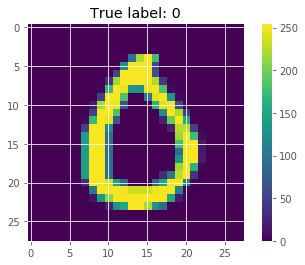

In [19]:
plot_radom_image()  # zavolani funkce

## Normalizace
Pro neutonovou sit je vetsinou nejlepsi, kdyz vidi pouze hodnoty okolo nuly. Proto data (pixely) pretransformujeme tak, aby meli prumerem $0$ a rozptyl $1$.

Od kazdeho pixelu odecteme prumer vsech $\left(\text{predpokladejme, ze je roven} \frac{\text{PIXEL_DEPTH}}{2}\right)$ a vydelime rozpetim $\left(x_{\text{max}} - x_{\text{min}} = \text{PIXEL_DEPTH}\right)$.

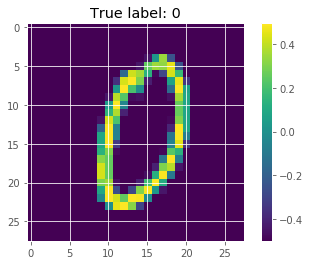

In [20]:
X = (X - (PIXEL_DEPTH / 2)) / PIXEL_DEPTH  # normalizujeme pixely
X = X.astype(np.float32)  # pretypujeme na np.float32
plot_radom_image()  # vykreslime transformovany obrazek

## Rozdeleni dat
Data rozdeline do tri podmnozin:
* **treninkova**: pro trenink (0.8)
* **validacni**: pro prubeznou kontrolu proti overfitingu behem treninku a ladeni hyperparametru (0.1)
* **testovaci**: pro konecnou kontrolu vysledku na modelu naprosto neznamych datech (0.1)

<img src=./images/train_valid_test.jpeg alt="Rozdeleni dat" style="width: 700px;"/>

In [21]:
TEST_PROPORTION = 0.1  # velikost testovaci sady
VALID_PROPORTION = 0.1  # velikost validacni sady
TRAIN_PROPORTION = 1 - TEST_PROPORTION - VALID_PROPORTION   # zbytek je pro trenink

num_samples = X.shape[0]  # pocet obrazku
test_size = int(TEST_PROPORTION * num_samples)  # pocet obrazku pro testovani
valid_size = int(VALID_PROPORTION * num_samples)  # pocet obrazku pro validaci
train_size = int(TRAIN_PROPORTION * num_samples)  # pocet obrazku pro trenink
print("Test size:  ", test_size)  # vypis pocet obrazku pro testovani
print("Valid size: ", valid_size)  # vypis pocet obrazku pro validaci
print("Train size:", train_size)  # vypis pocet obrazku pro trenink

X_train = X[:train_size]  # prvnich (train_size) obrazku pro trenink
y_train = y[:train_size]  # prvnich (train_size) obrazku pro trenink

X_valid = X[train_size : (train_size + valid_size)]  # (train_size) az (train_size + valid_size) pro validaci
y_valid = y[train_size : (train_size + valid_size)]  # (train_size) az (train_size + valid_size) pro validaci

X_test = X[(train_size + valid_size):]  # zbytek pro testovani
y_test = y[(train_size + valid_size):]  # zbytek pro testovani

Test size:   4200
Valid size:  4200
Train size: 33600


Abychom zabranili tomu, ze data jsou poskladana za sebou napriklad podle prislusnosti ka dane tride, musime je posprehazet. Pouzijeme na to funkci z balicku *scikit-learn*.

In [22]:
X_train, y_train = skl.utils.shuffle(X_train, y_train)  # posprehazime
X_valid, y_valid = skl.utils.shuffle(X_valid, y_valid)  # posprehazime
X_test, y_test = skl.utils.shuffle(X_test, y_test)  # posprehazime

## Ulozeni zpracovanych dat
Abychom celou proceduru tohoto notebooku nemuseli opakovat pred kazdym treninkem, takto pripravena data vlozime do jednoho slovniku a ulozime v binarni podobe na disk. To nam umozni jejich rychle a snadne nacteni bez dalsiho preprocessingu.

In [23]:
# vse ulozime do jednoho slovniku
save = {'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test}

SAVE_PATH = './data/MNIST.pkl'  # cesta pro ulozeni souboru

with open(file=SAVE_PATH, mode='wb') as save_file:  # otevreme tento soubor a pojmenujeme 'save_file'
    pickle.dump(file=save_file, obj=save)  # ulozime do nej slovnik 'save'